In [ ]:
#hide
from utils import *

# Variants of SGD

## Let's start with SGD

In [ ]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [ ]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [ ]:
def get_learner(**kwargs):
    return cnn_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [ ]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

In [ ]:
learn = get_learner(opt_func=SGD)

(0.017378008365631102, 3.019951861915615e-07)

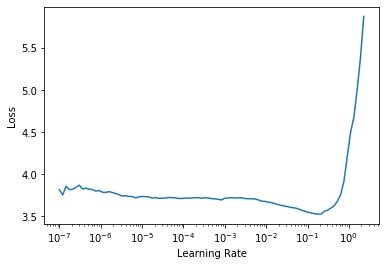

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

## A generic optimizer

In [ ]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

In [ ]:
opt_func = partial(Optimizer, cbs=[sgd_step])

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

## Momentum

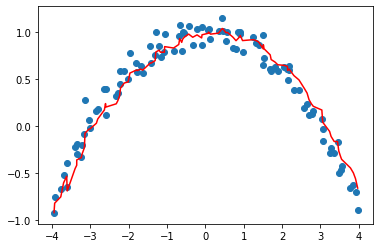

In [ ]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
plt.scatter(x1,y1)
idx = x1.argsort()
beta,avg,res = 0.7,0,[]
for i in idx:
    avg = beta * avg + (1-beta) * y1[i]
    res.append(avg/(1-beta**(i+1)))
plt.plot(x1[idx],np.array(res), color='red');

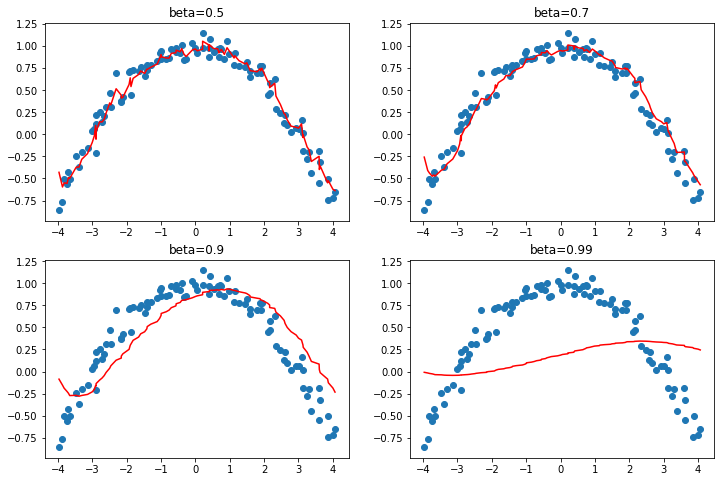

In [ ]:
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
idx = x1.argsort()
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(x1,y1)
    avg,res = 0,[]
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]
        res.append(avg)#/(1-beta**(i+1)))
    ax.plot(x1[idx],np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [ ]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

In [ ]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [ ]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

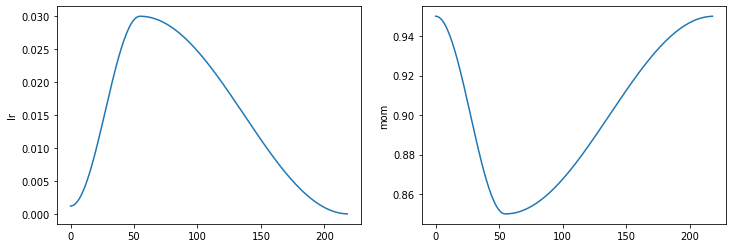

In [ ]:
learn.recorder.plot_sched()

## RMSProp

In [ ]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_avg*sqr_mom + p.grad.data**2}

In [ ]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

## Adam

## Decoupled weight_decay